In [1]:
import sklearn
import pickle as pkl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Benchmarking Geneformer

Here we benchmark four models, with two baselines. These models are tasked with cell type classification, using the Chron's disease small intestine dataset from 
Elmentaite et al. (2020), Developmental Cell. This dataset contains approximately 22,500 single cells from both healthy children aged 4-13 and chidlren with Chron's disease. This dataset contains 31 unique cell types which we assume to be annotated accurately. This dataset was held out of our pre-training dataset as all diseased samples were removed.

- Baseline 1) scRNA workflow: this model uses PCA with 10 components and random forest on normalized and log transformed expression counts to produce a result.
- Baseline 2) geneformer-qa, a model trained for approximately 100 steps with approximately random weights. We expect this model to perform no differently than working on counts directly.
- geneformer-10M + geneformer106M as described in the model cards.

First, we download the dataset from czi that we are interested in, and then create the requisite sc_memmap dataset object.

In [4]:
import cellxgene_census
CENSUS_VERSION = "2023-12-15"
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(census, "Homo sapiens",
            obs_value_filter='dataset_id=="8e47ed12-c658-4252-b126-381df8d52a3d"',
        )
adata.obs.cell_type.value_counts()
adata.obs['cell_type'].unique()

array(['CD4-positive, alpha-beta T cell', 'transit amplifying cell',
       'IgA plasma cell', 'intestine goblet cell', 'IgG plasma cell',
       'B cell', 'fibroblast', 'intestinal crypt stem cell', 'enterocyte',
       'memory B cell', 'T follicular helper cell',
       'conventional dendritic cell', 'endothelial cell of artery',
       'M cell of gut', 'enteroendocrine cell', 'vein endothelial cell',
       'activated CD4-positive, alpha-beta T cell, human', 'monocyte',
       'myofibroblast cell', 'pericyte', 'regulatory T cell',
       'endothelial cell of lymphatic vessel',
       'plasmacytoid dendritic cell', 'plasma cell', 'gamma-delta T cell',
       'mast cell', 'glial cell', 'dendritic cell, human',
       'CD8-positive, alpha-beta T cell', 'myeloid cell',
       'intestinal tuft cell'], dtype=object)

In [6]:
import scanpy as sc
import os

BIONEMO_HOME = os.environ.get('BIONEMO_HOME')
if BIONEMO_HOME is None:
    raise ValueError('BIONEMO_HOME env var must be set')

OUTPUT_DIR = f"{BIONEMO_HOME}/celltype-bench-dataset/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE = "human_dataset.h5ad"

output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
adata.write(output_path)

print(f"Data saved to {output_path}")
#NBVAL_CHECK_OUTPUT

Data saved to /workspace/bionemo/celltype-bench-dataset/human_dataset.h5ad


### Create the scmemmap object, check outputs

Importantly, the .npy files are used by BioNeMo dataset object. `features.csv` contains the metadata requested, in this case cell_type. It's important that the output of our model has the same order as `features.csv`, as this contains the labels used in the following benchmark.

In [4]:
%%bash
python $BIONEMO_HOME/bionemo/data/singlecell/sc_memmap.py --data-path $BIONEMO_HOME/celltype-bench-dataset/ --save-path $BIONEMO_HOME/celltype-bench-dataset/ --obs-cols cell_type --strict-metadata

Found 1 files
Starting to create memmap files...


[NeMo W 2024-09-12 10:48:57 sc_memmap:291] Data path found, not writing over it. If you want to override the data, re-run with --override-metadata


Metadata already exists, loading...
Writing data into memmaps to /workspace/bionemo/celltype-bench-dataset...
[NeMo I 2024-09-12 10:48:57 sc_memmap:219] pt_running_el: 0, cur_count: 0


Merging AnnData into numpy memaps...: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Saving dataframe ...
Done creating dataset ...


In [5]:
%%bash
ls $BIONEMO_HOME/celltype-bench-dataset/

features.csv
gene_expression_data.npy
gene_expression_ind.npy
gene_expression_ptr.npy
human_dataset.h5ad
infer_results_106M.pkl
metadata.json


###  Execute inference

We run inference on all there of our models, which are downloaded by `download_artifacts.py`

In [ ]:
%%bash

cd $BIONEMO_HOME

python download_artifacts.py --models geneformer_106M_240530 geneformer_10M_240530 geneformer --source pbss --model_dir $BIONEMO_HOME/models --verbose

mkdir -p $BIONEMO_HOME/examples/tests/test_data/cellxgene_2023-12-15_small/processed_data/train
mkdir -p $BIONEMO_HOME/examples/tests/test_data/cellxgene_2023-12-15_small/processed_data/val
mkdir -p $BIONEMO_HOME/examples/tests/test_data/cellxgene_2023-12-15_small/processed_data/test

# IMPORTANT- running inference with more than one device (++trainer.devices arg) can lead to a mismatch between `features.csv` and embeddings as result order is non-deterministic.

python bionemo/model/infer.py \
    --config-dir examples/singlecell/geneformer/conf \
    --config-name infer.yaml \
    ++model.batch_size=1 \
    ++model.micro_batch_size=1 \
    ++model.data.batch_size=64 \
    ++trainer.devices=1 \
    ++trainer.precision=bf16-mixed \
    ++model.downstream_task.restore_from_path=$BIONEMO_HOME/models/singlecell/geneformer/geneformer-106M-240530.nemo \
    ++model.data.output_fname=$BIONEMO_HOME/celltype-bench-dataset/infer_results_106M.pkl \
    ++model.tensor_model_parallel=1 \
    ++model.data.dataset_path=$BIONEMO_HOME/celltype-bench-dataset \
    ++model.data.train_dataset_path=$BIONEMO_HOME/examples/tests/test_data/cellxgene_2023-12-15_small/processed_data/train \
    ++model.data.val_dataset_path=$BIONEMO_HOME/examples/tests/test_data/cellxgene_2023-12-15_small/processed_data/val \
    ++model.data.test_dataset_path=$BIONEMO_HOME/examples/tests/test_data/cellxgene_2023-12-15_small/processed_data/test

In [7]:
%%bash

ls $BIONEMO_HOME/celltype-bench-dataset/infer_results_106M.pkl
#NBVAL_CHECK_OUTPUT

/workspace/bionemo/celltype-bench-dataset/infer_results_106M.pkl


### Benchmarking 

See below the benchmarking snippet. We take in a datavector, and a set of labels. We optionally fit PCA and then a RF model inside cross validation. Metrics are using the `macro` (average over each class) for handling multi-class labels. Additionally, we return the confusion matrix for further investigation.

In [8]:
def run_benchmark(data, labels, use_pca=True):
    ''' 
    data - contains the single cell expression (or whatever feature) in each row.
    labels - contains the string label for each cell
    
    data_shape (R, C)
    labels_shape (R,)
    '''
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.random_projection import GaussianRandomProjection
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import StratifiedKFold, cross_validate
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
    from sklearn.decomposition import PCA
    from sklearn.model_selection import cross_val_predict

    np.random.seed(1337)
    # Define the target dimension 'n_components'
    n_components = 10  # for example, adjust based on your specific needs

    # Create a pipeline that includes Gaussian random projection and RandomForestClassifier
    if use_pca:
        pipeline = Pipeline([
            ('projection', PCA(n_components=n_components)),
            ('classifier', RandomForestClassifier(class_weight='balanced'))
        ])
    else:
        pipeline = Pipeline([
            ('classifier', RandomForestClassifier(class_weight='balanced'))
        ])

    # Set up StratifiedKFold to ensure each fold reflects the overall distribution of labels
    cv = StratifiedKFold(n_splits=5)

    # Define the scoring functions
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='macro'),  # 'macro' averages over classes
        'recall': make_scorer(recall_score, average='macro'),
        'f1_score': make_scorer(f1_score, average='macro'),
        # 'roc_auc' requires probability or decision function; hence use multi_class if applicable
        'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True),
        # 'test': make_scorer(dummy_func)
    }

    # Perform stratified cross-validation with multiple metrics using the pipeline
    results = cross_validate(pipeline, data, labels, cv=cv, scoring=scoring, return_train_score=False)

    # Print the cross-validation results
    print("Cross-validation metrics:")
    results_out = {}
    for metric, scores in results.items():
        if metric.startswith('test_'):
            results_out[metric] = (scores.mean(), scores.std())
            print(f"{metric[5:]}: {scores.mean():.3f} (+/- {scores.std():.3f})")
    
    predictions = cross_val_predict(pipeline, data, labels, cv=cv)

    # Return confusion matrix and metrics.
    conf_matrix = confusion_matrix(labels, predictions)
    
    return results_out, conf_matrix

In [9]:
import pickle as pkl
# Loadup the 106M parameter model predictions
with open(f'{BIONEMO_HOME}/celltype-bench-dataset/infer_results_106M.pkl', 'rb') as fd:
     infer_results = pkl.load(fd)
print(infer_results[-1]['embeddings'].shape)
infer_Xs_106M = np.array([x['embeddings'] for x in infer_results])
#NBVAL_CHECK_OUTPUT

(768,)


In [10]:
import pandas as pd
import scanpy
import numpy as np
# Now fetch the class labels and raw expression for the same dataset. These are used as labels in classification and as one of our baselines.

infer_metadata = pd.read_csv(f'{BIONEMO_HOME}/celltype-bench-dataset/features.csv')
raw_data = scanpy.read(f'{BIONEMO_HOME}/celltype-bench-dataset/human_dataset.h5ad')
raw_Xs = np.asarray(raw_data.X.todense())
# Here we perform a norm over the total counts for each cell, adding a pseudocount to assist with the following logarithm.
normed_Xs = (raw_Xs + 1) / raw_Xs.sum(axis=1, keepdims=True)
logp1_Xs = np.log( normed_Xs )

Text(0.5, 1.0, 'Cell type counts for classification dataset')

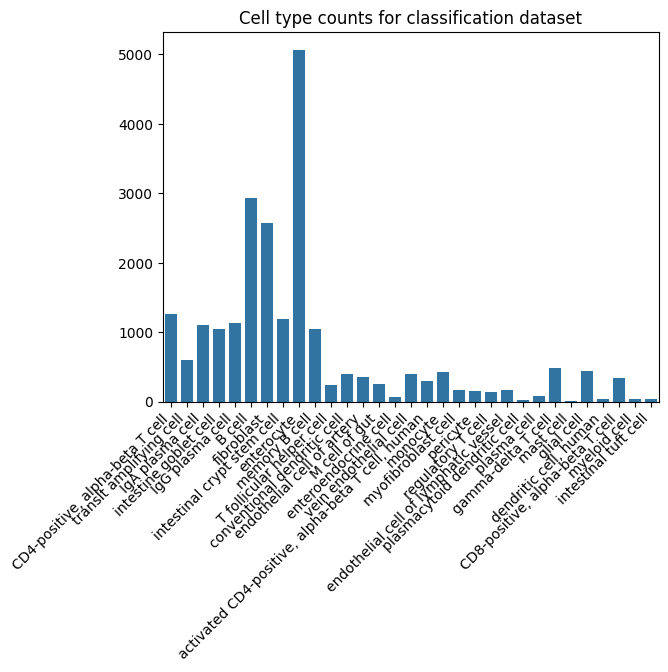

In [11]:
# Now we look at our dataset, how is the distribution of cell counts? Its clear that certain celltypes dominate the dataset, this is good to keep in mind when investigating models. 
#  we expect the macro averages and F1-score to be the most reliable metrics for overall performance.
from collections import Counter
import seaborn as sb

labels = infer_metadata['cell_type'].values
label_counts = Counter(labels)

ax = sb.barplot(x=label_counts.keys(), y=label_counts.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Cell type counts for classification dataset")

In [12]:
# Now we assign integer labels to each of our strings. These do not need to be transformed into one-hot vectors as Random Forest is non-parametric.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
print(integer_labels)
#NBVAL_CHECK_OUTPUT

[ 1 29  1 ... 14 12  3]


(array([9.97710900e+06, 1.26189975e+08, 6.33319495e+08, 5.88568351e+08,
        5.25076500e+06, 1.32944300e+06, 3.54771000e+05, 5.94530000e+04,
        9.95400000e+03, 2.01200000e+03]),
 array([-11.93355465, -10.77401161,  -9.61446857,  -8.45492649,
         -7.29538298,  -6.13584042,  -4.97629738,  -3.81675458,
         -2.65721154,  -1.49766874,  -0.33812588]),
 <BarContainer object of 10 artists>)

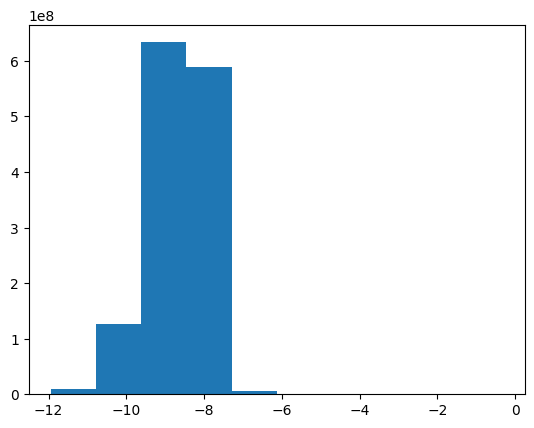

In [13]:
import matplotlib.pyplot as pyplot
# Distribution of log transforms, looks decent.
pyplot.hist(logp1_Xs.flatten())

In [14]:
def plot_cm(cm, labels=label_encoder.classes_):
    '''
    Helper function for visualizing accuracy across labels.
    '''
    from matplotlib.colors import BoundaryNorm, ListedColormap

    # Example confusion matrix (replace with your actual data)
    conf_matrix = np.random.rand(31, 31)

    # Define the bins and the color map
    bounds = np.arange(0.0, 1.1, 0.1)
    cmap = ListedColormap(sb.color_palette("RdYlBu_r", len(bounds) - 1))
    norm = BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1, clip=True)

    _ = sb.heatmap(cm / cm.sum(axis=0),cmap=cmap, norm=norm, cbar_kws={"ticks": bounds}, linewidths=0.5, linecolor='black', xticklabels=labels, yticklabels=labels)
    pyplot.xticks(rotation=45, ha='right')
    _ = pyplot.yticks(rotation=0)

### Execute benchmarks

Finally we execute our benchmarks, and collect results and confusion matrix. You can see in the figures below, we plot the performance by cell type for each model (confusion matrix heatmap). Perhaps unsurprisingly, we see that the most frequent cell type (enterocyte) has the highest accuracy across all models. This suggests bias in the model due to unbalanced data, however, further investigation is beyond the scope of this tutorial. Furthermore, we see continually improved performance as we move through the models, from baselines, to our provided pretrained model.

Perhaps most interesting is the 106M parameter model, which clearly outperforms all other models by all metrics, but especially by F1-score. This suggests that training larger models based on geneformer perform well, and that more work may be done.

In [15]:
logp1_results, logp1_cm = run_benchmark(logp1_Xs, integer_labels)
#NBVAL_CHECK_OUTPUT

Cross-validation metrics:
accuracy: 0.787 (+/- 0.029)
precision: 0.689 (+/- 0.039)
recall: 0.573 (+/- 0.014)
f1_score: 0.593 (+/- 0.014)
roc_auc: 0.974 (+/- 0.006)


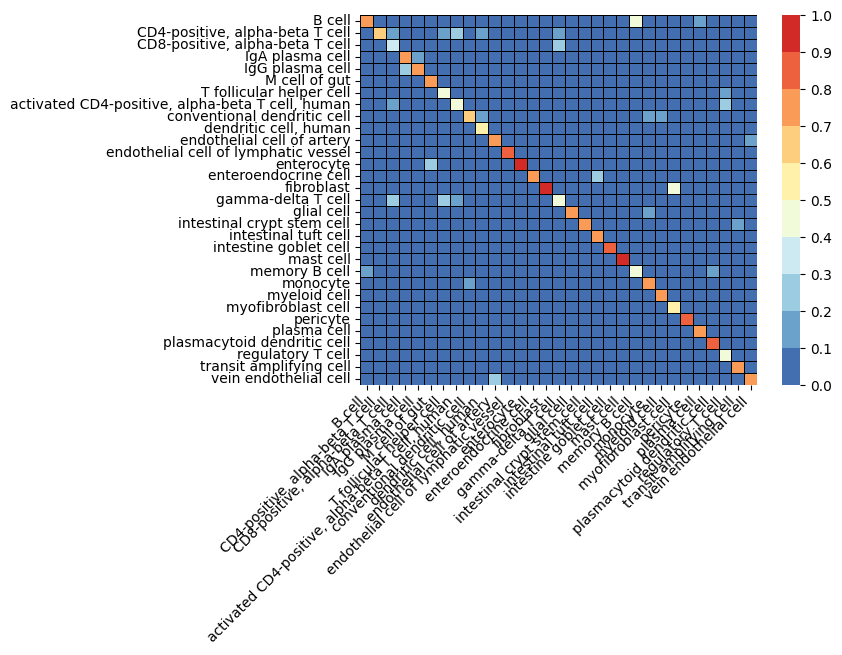

In [16]:
plot_cm(logp1_cm)

In [17]:
xs_106m_results, xs_106m_cm = run_benchmark(infer_Xs_106M, integer_labels, use_pca=False)
#NBVAL_CHECK_OUTPUT

Cross-validation metrics:
accuracy: 0.912 (+/- 0.016)
precision: 0.918 (+/- 0.017)
recall: 0.835 (+/- 0.014)
f1_score: 0.858 (+/- 0.013)
roc_auc: 0.993 (+/- 0.002)


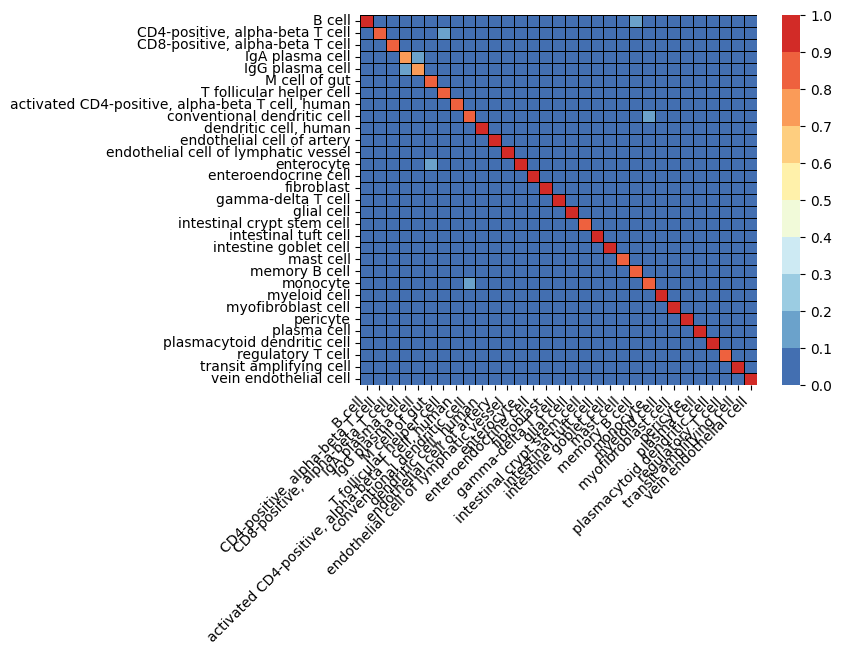

In [18]:
plot_cm(xs_106m_cm)

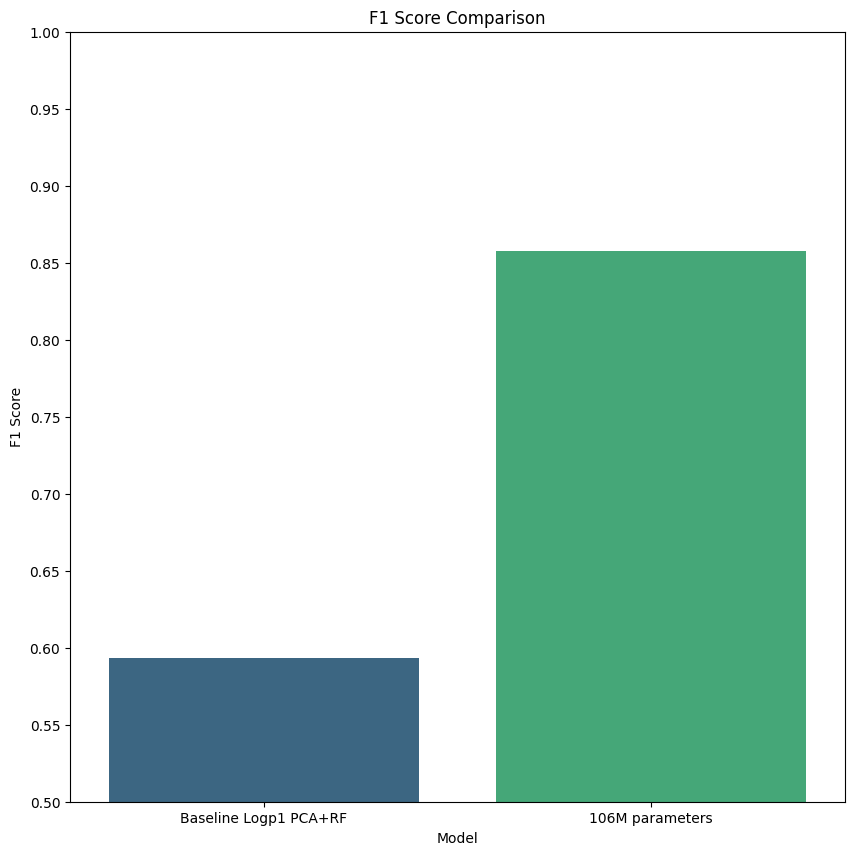

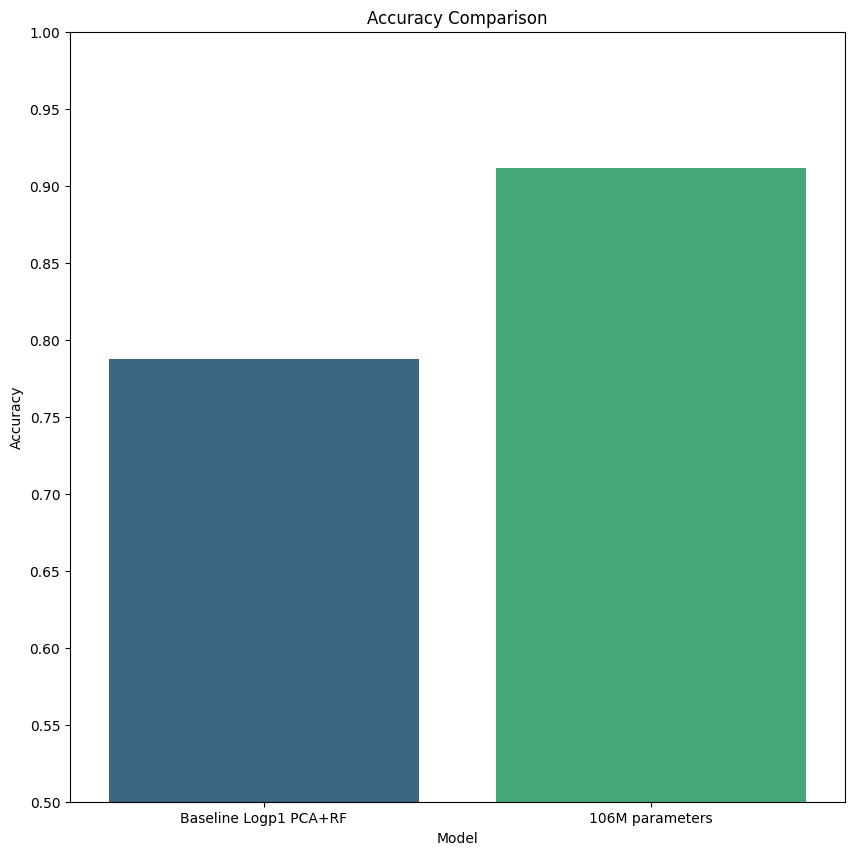

In [19]:
data = {
    'model': ['Baseline Logp1 PCA+RF', '106M parameters'],
    'f1_score_mean': [
        logp1_results['test_f1_score'][0],
        xs_106m_results['test_f1_score'][0],
    ],
    'f1_score_std': [
        logp1_results['test_f1_score'][1],
        xs_106m_results['test_f1_score'][1],
    ],
    'accuracy_mean': [
        logp1_results['test_accuracy'][0],
        xs_106m_results['test_accuracy'][0],
    ],
    'accuracy_std': [
        logp1_results['test_accuracy'][1],
        xs_106m_results['test_accuracy'][1],
    ]
}

df = pd.DataFrame(data)

fig, ax = pyplot.subplots(figsize=(10, 10))
# F1 Score plot
sb.barplot(x='model', y='f1_score_mean', data=df, capsize=0.2, palette='viridis', ax=ax)
ax.set_title('F1 Score Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_yticks(np.arange(.5, 1.05, .05))
ax.set_ylim(.5, 1.0)
pyplot.savefig("F1-score-models.png")

# Accuracy plot
fig, ax = pyplot.subplots(figsize=(10, 10))
sb.barplot(x='model', y='accuracy_mean', data=df, ax=ax, capsize=0.2, palette='viridis')
ax.set_title('Accuracy Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(.5, 1.05, .05))
ax.set_ylim(.5, 1.0)
pyplot.savefig("average-accuracy-models.png")
